<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/flops_bw_microbench.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import time

values = []
def calc_flops(func, sz, loop_iters):
  inputs = [torch.randn(sz, device='cuda')]
  for _ in range(5):
    func(*inputs)
  torch.cuda.synchronize()
  iters = 100
  begin = time.time()
  for _ in range(iters):
    func(*inputs)
  torch.cuda.synchronize()
  t = (time.time()-begin)
  iters_per_s = iters/t
  flops = sz * loop_iters
  bytes_per_elem = 4
  num_reads = 1
  num_writes = 1
  mem_bw = sz * (num_reads + num_writes) * bytes_per_elem
  print(f"{loop_iters} ops")
  print(f"itr time: {t *1e6 / iters}")
  print(f"FLOPS: {iters_per_s * flops/1e12:.2f} TF/s")
  print(f"Mem B/W: {iters_per_s * mem_bw/1e9:.2f} GB/s")
  print()
  values.append((t / iters, iters_per_s * flops, iters_per_s * mem_bw))

for iters in [2**i for i in range(10)]:
  def f(x):
    for _ in range(iters):
      x = x * 2
    return x

  sz = 2**24
  f = torch.jit.trace(f, (torch.randn(sz, device='cuda')))
  with torch.jit.fuser("fuser2"):
    calc_flops(f, sz, iters)
  # print(values)

1 ops
itr time: 551.8865585327148
FLOPS: 0.03 TF/s
Mem B/W: 243.20 GB/s

2 ops
itr time: 536.1175537109375
FLOPS: 0.06 TF/s
Mem B/W: 250.35 GB/s

4 ops
itr time: 536.8518829345703
FLOPS: 0.13 TF/s
Mem B/W: 250.01 GB/s

8 ops
itr time: 546.0476875305176
FLOPS: 0.25 TF/s
Mem B/W: 245.80 GB/s

16 ops
itr time: 547.6737022399902
FLOPS: 0.49 TF/s
Mem B/W: 245.07 GB/s

32 ops
itr time: 545.7353591918945
FLOPS: 0.98 TF/s
Mem B/W: 245.94 GB/s

64 ops
itr time: 576.3602256774902
FLOPS: 1.86 TF/s
Mem B/W: 232.87 GB/s

128 ops
itr time: 906.0049057006836
FLOPS: 2.37 TF/s
Mem B/W: 148.14 GB/s

256 ops
itr time: 1454.777717590332
FLOPS: 2.95 TF/s
Mem B/W: 92.26 GB/s

512 ops
itr time: 3782.1030616760254
FLOPS: 2.27 TF/s
Mem B/W: 35.49 GB/s



In [ ]:
times, flops, mem_bw = zip(*values)

In [ ]:
!nvidia-smi

Mon Jan 31 13:08:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |   6442MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

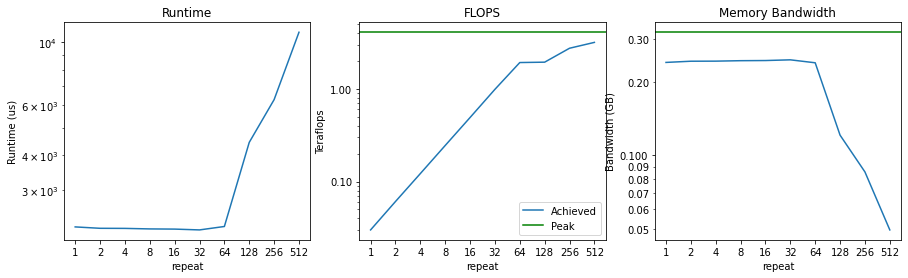

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

peak_tflops = 8.141/2
peak_bw = 0.32

gs = gridspec.GridSpec(1, 3)
plt.figure(figsize=(15,4))

plt.subplot(gs[0])
plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Runtime (us)')
plt.plot([str(2**i) for i in range(len(times))], [i * 1e6 for i in times])
plt.title("Runtime")
# plt.show()

plt.subplot(gs[1])

peak = plt.axhline(peak_tflops, color = 'g')
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Teraflops')
res, = plt.plot([str(2**i) for i in range(len(flops))], [i/1e12 for i in flops])
ax = plt.gca()
import matplotlib.ticker as mticker
plt.legend([res, peak], ['Achieved', 'Peak'])

plt.title("FLOPS")
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())


plt.subplot(gs[2])
peak = plt.axhline(peak_bw, color = 'g')

plt.yscale('log')
plt.xlabel('repeat')
plt.ylabel('Bandwidth (GB)')
plt.plot([str(2**i) for i in range(len(mem_bw))], [i/1e12 for i in mem_bw])
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())

import matplotlib.ticker as mticker

plt.title("Memory Bandwidth")
plt.savefig('microbench.png', bbox_inches='tight')